In [1]:
# B02 — Descriptives & ARDL-ready dataset  
# -------------------------------------------------------------------
from __future__ import annotations
import warnings, glob, re
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)

# ----------------------- Config -----------------------
SEARCH_PATTERNS = [
    "data/processed/master_panel_*.csv",
    "data/processed/master_panel.csv",
    "data/processed/master_panel_*.parquet",
    "data/processed/master_panel.parquet",
    "/mnt/data/master_panel_*.csv",
    "/mnt/data/master_panel.csv",
    "/mnt/data/master_panel_*.parquet",
    "/mnt/data/master_panel.parquet",
]
OUT_DIR = Path("data/processed")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Analysis window (set to None to keep full span)
START_Q = "2005Q1"
END_Q   = None  # e.g., "2024Q4"

# Event anchors (quarters)
BREXIT_Q   = "2016Q3"
COVID_Q    = "2020Q2"
UKRAINE_Q  = "2022Q1"

# ------- Synonym groups -------
GDP_REAL_SYNS   = ["gdp_real_mn","gdp_real_abmi","gdp_real","real_gdp_abmi","rgdp_abmi","rgdp"]
GDP_NOM_SYNS    = ["gdp_nom_mn","gdp_nominal_mn","gdp_nominal","ybha_nominal","ybha_mn"]
DEFLATOR_SYNS   = ["gdp_deflator_index","gdp_deflator_ybgb","ybgb_index","deflator_index","ybgb"]
MOD_TOT_NOM     = ["total","mod_total_nom","mod_total_nominal","mod_total_nom_mn","mod_total_gbp"]
MOD_CUR_NOM     = ["current","mod_cur_nom","mod_current_nom","mod_current_nominal","mod_current_nom_mn"]
MOD_CAP_NOM     = ["capital","mod_cap_nom","mod_capital_nom","mod_capital_nominal","mod_cap_nom_mn"]
ESCOE_SYNS      = ["escoe_recession","escoe_rec","escoe_recession_flag"]

# ----------------------- Helpers -----------------------
def _read_any(p: Path) -> pd.DataFrame:
    if p.suffix.lower() == ".csv":
        return pd.read_csv(p)
    if p.suffix.lower() in {".parquet",".pq"}:
        return pd.read_parquet(p)
    raise ValueError(f"Unsupported file type: {p}")

def _list_master_candidates(patterns: list[str]) -> list[Path]:
    hits: list[Path] = []
    for pat in patterns:
        hits.extend([Path(x) for x in glob.glob(pat)])
    return [p for p in hits if p.is_file()]

def _has_measures(df: pd.DataFrame, measures: list[str]) -> int:
    if {"measure","period","value"}.issubset(df.columns):
        avail = set(df["measure"].astype(str).str.lower().unique())
    else:
        avail = set(map(str.lower, map(str, df.columns)))
    return sum(m.lower() in avail for m in measures)

def _find_best_master(patterns: list[str]) -> Path:
    cands = _list_master_candidates(patterns)
    if not cands:
        raise FileNotFoundError("No master panel found in expected locations.")
    anchor = GDP_REAL_SYNS + DEFLATOR_SYNS + MOD_TOT_NOM
    best, best_score, best_mtime = None, -1, -1
    for p in cands:
        try:
            df = _read_any(p)
            score = _has_measures(df, anchor)
            mtime = p.stat().st_mtime
            if score > best_score or (score == best_score and mtime > best_mtime):
                best, best_score, best_mtime = p, score, mtime
        except Exception:
            continue
    if best is None:
        raise FileNotFoundError("Found candidates but could not read any; please inspect files.")
    return best

def _normalize_quarter_strings(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    def _norm_one(x: str) -> str | None:
        if not x or x.lower() in {"nan","none"}: return None
        m = re.match(r"^(\d{4})[Qq](\d)$", x)
        if m:
            y, q = int(m.group(1)), int(m.group(2))
            return f"{y}Q{q}"
        dt = pd.to_datetime(x, errors="coerce", dayfirst=False)
        if pd.isna(dt): return None
        per = pd.Period(dt, freq="Q")
        return f"{per.year}Q{per.quarter}"
    return s.map(_norm_one)

def _quarter_end_index_from_any(df: pd.DataFrame) -> pd.DatetimeIndex:
    for c in ["quarter_end","Quarter_end","quarterEnd","QuarterEnd"]:
        if c in df.columns:
            dt = pd.to_datetime(df[c], errors="coerce")
            return dt.dropna().to_period("Q").to_timestamp(how="end")
    for c in ["period","quarter","Quarter","date","Date"]:
        if c in df.columns:
            norm = _normalize_quarter_strings(df[c])
            good = ~norm.isna()
            return pd.PeriodIndex(norm[good].tolist(), freq="Q").to_timestamp(how="end")
    if isinstance(df.index, pd.PeriodIndex):
        return df.index.to_timestamp(how="end")
    if isinstance(df.index, pd.DatetimeIndex):
        return df.index.to_period("Q").to_timestamp(how="end")
    raise ValueError("Could not infer quarter index from master panel; please add a 'period' or 'quarter_end' column.")

def _ensure_quarter_end_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.index = _quarter_end_index_from_any(out)
    out = out[~out.index.duplicated()].sort_index()
    return out

def _pick(df: pd.DataFrame, candidates: list[str]) -> str | None:
    cols = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in cols:
            return cols[c.lower()]
    return None

def _log(s: pd.Series, name: str | None = None) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    out = np.log(s.replace({0: np.nan}))
    if name: out.name = name
    return out

def _growth_pct(s: pd.Series, lag: int = 1, name: str | None = None) -> pd.Series:
    out = pd.to_numeric(s, errors="coerce").pct_change(lag) * 100.0
    if name: out.name = name
    return out

def _two_negative_quarters_flag(rgdp: pd.Series) -> pd.Series:
    qoq = _growth_pct(rgdp, 1)
    neg = qoq < 0
    blocks = (neg != neg.shift()).cumsum()
    runlen = blocks.groupby(blocks).transform("size")
    return (neg & (runlen >= 2)).rename("rec_tech")

# ----------------------- Load master -----------------------
master_path = _find_best_master(SEARCH_PATTERNS)
print(f"Using master panel: {master_path}")
raw = _read_any(master_path)

# Long -> Wide if required
if {"measure","period","value"}.issubset(raw.columns):
    tmp = raw.copy()
    tmp["period"] = _normalize_quarter_strings(tmp["period"])
    tmp = tmp.loc[~tmp["period"].isna()].copy()
    wide = tmp.pivot_table(index="period", columns="measure", values="value", aggfunc="last")
    df = wide.reset_index().rename(columns={"period":"period"})
else:
    df = raw.copy()

# Make sure we have a clean quarter-end index
df = _ensure_quarter_end_index(df)

# Optional analysis window
if START_Q or END_Q:
    per = df.index.to_period("Q")
    mask = pd.Series(True, index=df.index)
    if START_Q: mask &= per >= pd.Period(START_Q, freq="Q")
    if END_Q:   mask &= per <= pd.Period(END_Q,   freq="Q")
    df = df.loc[mask].copy()

print(f"Span: {df.index.min().date()} — {df.index.max().date()}  (n={len(df)})")

# ----------------------- Build real series (if needed) -----------------------
gdp_real_col = _pick(df, GDP_REAL_SYNS)
if gdp_real_col is None:
    gdp_nom_col  = _pick(df, GDP_NOM_SYNS)
    deflator_col = _pick(df, DEFLATOR_SYNS)
    if gdp_nom_col and deflator_col:
        denom = (pd.to_numeric(df[deflator_col], errors="coerce") / 100.0).replace({0: np.nan})
        df["gdp_real_mn"] = pd.to_numeric(df[gdp_nom_col], errors="coerce") / denom
        gdp_real_col = "gdp_real_mn"
    else:
        raise KeyError(f"Could not find/construct real GDP. "
                       f"Looked for real {GDP_REAL_SYNS} or nominal {GDP_NOM_SYNS} + deflator {DEFLATOR_SYNS}.")
tot_nom_col = _pick(df, MOD_TOT_NOM)
cur_nom_col = _pick(df, MOD_CUR_NOM)
cap_nom_col = _pick(df, MOD_CAP_NOM)
deflator_col = _pick(df, DEFLATOR_SYNS)
if not deflator_col:
    raise KeyError(f"Missing GDP deflator in master. Tried: {DEFLATOR_SYNS}")
denom = (pd.to_numeric(df[deflator_col], errors="coerce") / 100.0).replace({0: np.nan})

if tot_nom_col:
    df["mod_total_real"] = pd.to_numeric(df[tot_nom_col], errors="coerce") / denom
if cur_nom_col:
    df["mod_cur_real"]   = pd.to_numeric(df[cur_nom_col], errors="coerce") / denom
if cap_nom_col:
    df["mod_cap_real"]   = pd.to_numeric(df[cap_nom_col], errors="coerce") / denom

# ----------------------- Log levels & log-differences -----------------------
log_map = {
    "ln_gdp_real":      df[gdp_real_col],
    "ln_mod_total":     df.get("mod_total_real"),
    "ln_mod_current":   df.get("mod_cur_real"),
    "ln_mod_capital":   df.get("mod_cap_real"),
}
for name, series in list(log_map.items()):
    if series is None:
        log_map.pop(name, None)
        continue
    df[name] = np.log(pd.to_numeric(series, errors="coerce").replace({0: np.nan}))

for base in [k for k in log_map.keys()]:
    df[f"d_{base}"]  = df[base].diff(1)
for base in [k for k in log_map.keys()]:
    df[f"d4_{base}"] = df[base].diff(4)

# ----------------------- 4Q Capital smoothing & shares -----------------------
if "mod_cap_real" in df.columns:
    df["mod_cap_real_4qsum"] = pd.to_numeric(df["mod_cap_real"], errors="coerce").rolling(4, min_periods=1).sum()
    df["mod_cap_real_4qma"]  = pd.to_numeric(df["mod_cap_real"], errors="coerce").rolling(4, min_periods=1).mean()
if {"mod_cap_real","mod_total_real"}.issubset(df.columns):
    df["cap_share"]      = df["mod_cap_real"] / df["mod_total_real"]
    df["cap_share_4qma"] = df["cap_share"].rolling(4, min_periods=1).mean()

# ----------------------- Event dummies & recession flags -----------------------
per = df.index.to_period("Q")
def _step_from(q: str) -> pd.Series:  return (per >= pd.Period(q, freq="Q")).astype(int)
def _pulse_at(q: str) -> pd.Series:   return (per == pd.Period(q, freq="Q")).astype(int)

df["D_brexit_step"]  = _step_from(BREXIT_Q)
df["D_covid_step"]   = _step_from(COVID_Q)
df["D_ukraine_step"] = _step_from(UKRAINE_Q)
df["D_brexit_qtr"]   = _pulse_at(BREXIT_Q)
df["D_covid_qtr"]    = _pulse_at(COVID_Q)
df["D_ukraine_qtr"]  = _pulse_at(UKRAINE_Q)
df["rec_tech"]       = _two_negative_quarters_flag(df[gdp_real_col])

escoe_col = _pick(df, ESCOE_SYNS)
if escoe_col:
    df["rec_escoe"] = (pd.to_numeric(df[escoe_col], errors="coerce") > 0).astype(int)

df["trend"] = np.arange(1, len(df)+1)

# ----------------------- Tidy ARDL-ready view -----------------------
prefer = [
    gdp_real_col,
    "mod_total_real","mod_cur_real","mod_cap_real",
    "ln_gdp_real","ln_mod_total","ln_mod_current","ln_mod_capital",
    "d_ln_gdp_real","d_ln_mod_total","d_ln_mod_current","d_ln_mod_capital",
    "d4_ln_gdp_real","d4_ln_mod_total","d4_ln_mod_current","d4_ln_mod_capital",
    "mod_cap_real_4qsum","mod_cap_real_4qma","cap_share","cap_share_4qma",
    "D_brexit_step","D_covid_step","D_ukraine_step",
    "D_brexit_qtr","D_covid_qtr","D_ukraine_qtr",
    "rec_tech","rec_escoe","trend",
]
existing = [c for c in prefer if c in df.columns]
ardl_ready = df[existing].copy()
ardl_ready = ardl_ready.rename(columns={gdp_real_col:"gdp_real"})

# ---------- Small Fix 1: remove cosmetic column label (from pivot) ----------
ardl_ready.columns.name = None

# ---------- Small Fix 2: trim to common sample for ARDL ----------
key = ["ln_mod_total", "ln_gdp_real", "d_ln_mod_total", "d_ln_gdp_real"]
have = [c for c in key if c in ardl_ready.columns]
if have:
    ardl_ready = ardl_ready.dropna(subset=have)

# (Optional) Small Fix 3: enforce a hard window if desired
# ardl_ready = ardl_ready.loc[(ardl_ready.index.to_period("Q") <= pd.Period("2024Q1"))]

# ----------------------- Save & preview -----------------------
OUT_DIR.mkdir(parents=True, exist_ok=True)
out_csv = OUT_DIR / "ardl_ready_panel.csv"
out_pq  = OUT_DIR / "ardl_ready_panel.parquet"
ardl_ready.reset_index(names="quarter_end").to_csv(out_csv, index=False)
ardl_ready.to_parquet(out_pq, index=True)

print("Saved:")
print(f" - {out_csv}")
print(f" - {out_pq}")
print("\nPreview:")
display(ardl_ready.tail(8))

# ----------------------- Basic descriptives -----------------------
num_cols = [c for c in ardl_ready.columns if ardl_ready[c].dtype.kind in "fc"]
desc = ardl_ready[num_cols].describe().T
print("Numeric descriptives (count, mean, std, min, quartiles, max):")
display(desc)

growth_cols = [c for c in ardl_ready.columns if c.startswith("d_ln_")]
if growth_cols:
    corr = ardl_ready[growth_cols].corr()
    print("\nCorrelation matrix among d_ln variables:")
    display(corr)

Using master panel: data\processed\master_panel.csv
Span: 2005-03-31 — 2025-06-30  (n=82)
Saved:
 - data\processed\ardl_ready_panel.csv
 - data\processed\ardl_ready_panel.parquet

Preview:


,gdp_real,mod_total_real,mod_cur_real,mod_cap_real,ln_gdp_real,ln_mod_total,ln_mod_current,ln_mod_capital,d_ln_gdp_real,d_ln_mod_total,...,cap_share,cap_share_4qma,D_brexit_step,D_covid_step,D_ukraine_step,D_brexit_qtr,D_covid_qtr,D_ukraine_qtr,rec_tech,trend
2022-06-30 23:59:59.999999999,631258.0,14009.081736,8454.086781,5554.994955,13.355470,9.547461,9.042405,8.622453,0.003347,0.110560,...,0.396528,0.341195,1,1,1,0,0,0,False,70
2022-09-30 23:59:59.999999999,631977.0,13786.494538,8319.761668,5466.732870,13.356608,9.531445,9.026389,8.606436,0.001138,-0.016016,...,0.396528,0.359640,1,1,1,0,0,0,False,71
2022-12-31 23:59:59.999999999,634044.0,13452.519380,8118.217054,5334.302326,13.359874,9.506922,9.001866,8.581913,0.003265,-0.024523,...,0.396528,0.378084,1,1,1,0,0,0,False,72
2023-03-31 23:59:59.999999999,634428.0,13221.904762,7979.047619,5242.857143,13.360479,9.489630,8.984574,8.564622,0.000605,-0.017291,...,0.396528,0.396528,1,1,1,0,0,0,False,73
2023-06-30 23:59:59.999999999,634694.0,13284.644195,8666.666667,4617.977528,13.360898,9.494364,9.067240,8.437712,0.000419,0.004734,...,0.347618,0.384301,1,1,1,0,0,0,False,74
2023-09-30 23:59:59.999999999,634327.0,13161.410019,8586.270872,4575.139147,13.360320,9.485044,9.057920,8.428392,-0.000578,-0.009320,...,0.347618,0.372073,1,1,1,0,0,0,True,75
2023-12-31 23:59:59.999999999,633011.0,13137.037037,8570.370370,4566.666667,13.358243,9.483191,9.056066,8.426539,-0.002077,-0.001854,...,0.347618,0.359845,1,1,1,0,0,0,True,76
2024-03-31 23:59:59.999999999,638746.0,12980.786825,8468.435499,4512.351327,13.367262,9.471226,9.044101,8.414574,0.009019,-0.011965,...,0.347618,0.347618,1,1,1,0,0,0,False,77


Numeric descriptives (count, mean, std, min, quartiles, max):


,count,mean,std,min,25%,50%,75%,max
gdp_real,76.0,565098.157895,43417.835894,481769.000000,526630.000000,560989.500000,606493.250000,638746.000000
mod_total_real,76.0,11779.275907,802.954944,10743.923611,11158.364534,11475.080052,12347.469430,14009.081736
mod_cur_real,76.0,9513.007499,1260.382364,7979.047619,8313.873127,8705.276927,10928.279862,11343.060960
mod_cap_real,76.0,2266.268408,1427.012954,315.660112,1080.005050,2637.709206,3027.995521,5554.994955
ln_gdp_real,76.0,13.241862,0.076448,13.085220,13.174253,13.237453,13.315449,13.367262
ln_mod_total,76.0,9.371879,0.066500,9.282096,9.319945,9.347932,9.421206,9.547461
ln_mod_current,76.0,9.151806,0.131830,8.984574,9.025681,9.071683,9.299109,9.336361
ln_mod_capital,76.0,7.474883,0.781947,5.754666,6.984719,7.877663,8.015656,8.622453
d_ln_gdp_real,76.0,0.003151,0.033598,-0.227299,0.001074,0.004826,0.007448,0.155189
d_ln_mod_total,76.0,0.002232,0.025027,-0.062778,-0.008856,-0.004140,0.000914,0.110560



Correlation matrix among d_ln variables:


,d_ln_gdp_real,d_ln_mod_total,d_ln_mod_current,d_ln_mod_capital
d_ln_gdp_real,1.000000,0.282579,0.238303,0.037011
d_ln_mod_total,0.282579,1.000000,0.429423,0.339764
d_ln_mod_current,0.238303,0.429423,1.000000,-0.511407
d_ln_mod_capital,0.037011,0.339764,-0.511407,1.000000


Saved figure to: figures\d_ln_mod_capital_qoq_2005-06-30_to_2024-03-31.png


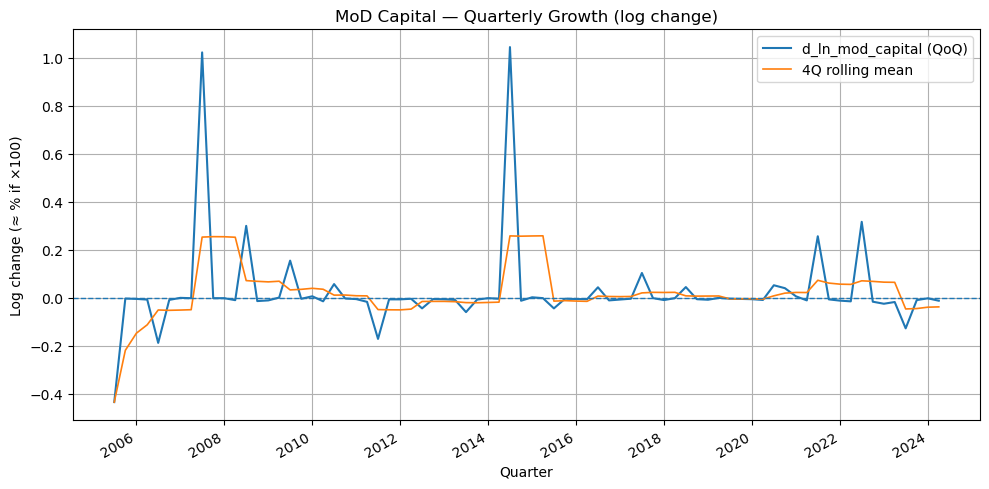

In [2]:
# Plot: d_ln_mod_capital (QoQ log change) + 4Q rolling mean, and save to figures/
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ---- Load ARDL-ready data if not already in memory ----
try:
    _ = ardl_ready  # check if it exists in the current session
except NameError:
    pq_path  = Path("data/processed/ardl_ready_panel.parquet")
    csv_path = Path("data/processed/ardl_ready_panel.csv")
    if pq_path.exists():
        ardl_ready = pd.read_parquet(pq_path)
    elif csv_path.exists():
        ardl_ready = pd.read_csv(csv_path, parse_dates=["quarter_end"]).set_index("quarter_end")
    else:
        raise FileNotFoundError("Could not find ardl_ready_panel in data/processed/")

# ---- Build series ----
s = pd.to_numeric(ardl_ready["d_ln_mod_capital"], errors="coerce").dropna()
s_ma = s.rolling(4, min_periods=1).mean()

# ---- Plot ----
fig, ax = plt.subplots(figsize=(10, 5))
s.plot(ax=ax, lw=1.5, label="d_ln_mod_capital (QoQ)")
s_ma.plot(ax=ax, lw=1.2, label="4Q rolling mean")
ax.axhline(0, lw=1, linestyle="--")
ax.set_title("MoD Capital — Quarterly Growth (log change)")
ax.set_xlabel("Quarter")
ax.set_ylabel("Log change (≈ % if ×100)")
ax.grid(True)
ax.legend()
plt.tight_layout()

# ---- Save to figures/ ----
fig_dir = Path("figures")
fig_dir.mkdir(parents=True, exist_ok=True)
start_str = s.index.min().date().isoformat()
end_str   = s.index.max().date().isoformat()
out_path = fig_dir / f"d_ln_mod_capital_qoq_{start_str}_to_{end_str}.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Saved figure to: {out_path}")

plt.show()

C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


=== Selected orders by AIC ===
 y lags (p): None
 exog lags: None
AIC: -348.597

=== ARDL results (levels form) ===
                                ARDL Model Results                                
Dep. Variable:               ln_mod_total   No. Observations:                   76
Model:             ARDL(5, 5, 0, 0, 0, 0)   Log Likelihood                 191.299
Method:                   Conditional MLE   S.D. of innovations              0.016
Date:                    Tue, 02 Sep 2025   AIC                           -348.597
Time:                            01:28:00   BIC                           -310.132
Sample:                        09-30-2006   HQIC                          -333.301
                             - 03-31-2024                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.9566      1.781      2.7

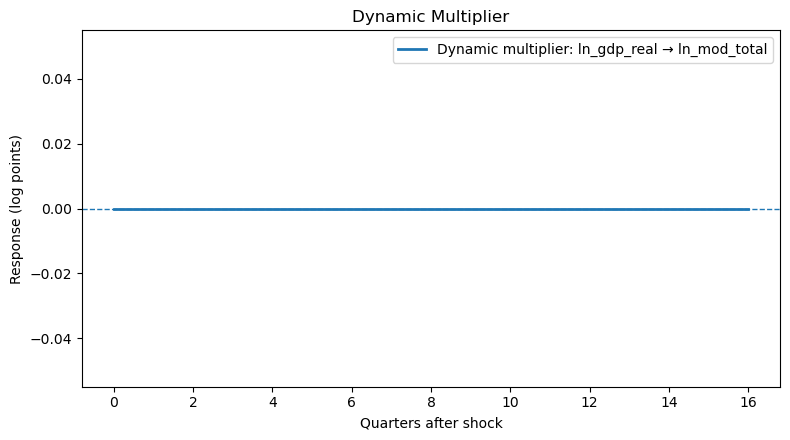

In [3]:
# ARDL/ECM for ln_mod_total on ln_gdp_real (+ event dummies)
# Robust to statsmodels API: uses maxorder (older) or maxlag_exog (newer) automatically.
import warnings, inspect
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL, ardl_select_order

# ---------------- Load ARDL-ready data ----------------
try:
    _ = ardl_ready  # reuse if already present
except NameError:
    pq = Path("data/processed/ardl_ready_panel.parquet")
    csv = Path("data/processed/ardl_ready_panel.csv")
    if pq.exists():
        ardl_ready = pd.read_parquet(pq)
    elif csv.exists():
        ardl_ready = pd.read_csv(csv, parse_dates=["quarter_end"]).set_index("quarter_end")
    else:
        raise FileNotFoundError("Cannot find data/processed/ardl_ready_panel.[parquet|csv]")

df = ardl_ready.copy()

# ---------------- Variables ----------------
ycol = "ln_mod_total"
xcore = ["ln_gdp_real"]
dummy_candidates = ["D_brexit_step","D_covid_step","D_ukraine_step",
                    "D_brexit_qtr","D_covid_qtr","D_ukraine_qtr"]
dums = [c for c in dummy_candidates if c in df.columns]

# Keep rows with y and core x present
keep = [ycol] + xcore
dfm = df.dropna(subset=keep).copy()
y = dfm[ycol]
X = dfm[xcore + dums]

# ---------------- AIC lag selection (API-robust) ----------------
max_lag_y = 6
# Build exog max-lag spec: GDP up to 6, dummies 0
exog_max = {"ln_gdp_real": 6}
for d in dums:
    exog_max[d] = 0

sel_kwargs = dict(endog=y, maxlag=max_lag_y, exog=X, trend="c", ic="aic")
sig = inspect.signature(ardl_select_order)
if "maxorder" in sig.parameters:
    sel_kwargs["maxorder"] = exog_max      # older API
elif "maxlag_exog" in sig.parameters:
    sel_kwargs["maxlag_exog"] = exog_max   # newer API
# else: fall back to same lag for all exog (not our case, but safe)

sel = ardl_select_order(**sel_kwargs)
model = sel.model
res = model.fit()

print("=== Selected orders by AIC ===")
print(f" y lags (p): {getattr(model, 'lags', None)}")
ex_lags = getattr(model, "exog_lags", None)
print(" exog lags:", ex_lags)
print(f"AIC: {res.aic:,.3f}\n")

print("=== ARDL results (levels form) ===")
print(res.summary())

# ---------------- Bounds test ----------------
try:
    from statsmodels.tsa.ardl import ardl_bounds_test
    bt = ardl_bounds_test(res, case=3)  # Case III: constant, no trend
    stat = getattr(bt, "stat", getattr(bt, "statistic", np.nan))
    cvs  = getattr(bt, "critical_values", getattr(bt, "cv", None))
    print("\n=== Bounds test (Pesaran–Shin–Smith, case III: constant) ===")
    print(f" F-statistic: {stat:.3f}")
    if cvs is not None:
        try:
            for k, v in cvs.items():
                i0, i1 = v[0], v[1]
                print(f"  {k} bounds: I(0)={i0:.3f}, I(1)={i1:.3f}")
        except Exception:
            print(cvs)
except Exception as e:
    print("\n[Note] Bounds test not available in this statsmodels build.")
    print(f"      Details: {e}")

# ---------------- Long-run elasticity ----------------
# Parse params named like 'L1.ln_mod_total', 'L0.ln_gdp_real', etc.
def _collect(prefix, name):
    out = []
    for pname, val in res.params.items():
        if pname.startswith(prefix) and pname.endswith(name):
            try:
                lag = int(pname.split(".")[0][1:])
            except Exception:
                lag = 0
            out.append((lag, float(val)))
    out.sort()
    return out

phi = _collect("L", ycol)             # AR lags on y
bet = _collect("L", "ln_gdp_real")    # distributed lags on x

phi_sum = sum(v for _, v in phi)
beta_sum = sum(v for _, v in bet)
lr = np.nan if (1 - phi_sum) == 0 else beta_sum / (1 - phi_sum)

print("\n=== Long-run elasticity of ln_mod_total w.r.t ln_gdp_real ===")
print(f" Sum of β (x lags): {beta_sum:.4f}")
print(f" Sum of φ (y lags): {phi_sum:.4f}")
print(f" Long-run elasticity: {lr:.4f}")

# ---------------- ECM (short-run dynamics) ----------------
# Δy_t ~ const + y_{t-1} + x_{t-1} + Σ_{i=1}^{p-1} Δy_{t-i} + Σ_{k=0}^{q-1} Δx_{t-k} + dummies
# Take p, q from the fitted names (robust to API differences)
p = max([lag for lag, _ in phi] + [0])
q = max([lag for lag, _ in bet] + [0])

work = dfm[[ycol, "ln_gdp_real"] + dums].copy()
work["dy"] = work[ycol].diff()
work["dx"] = work["ln_gdp_real"].diff()
work["y_lag1"] = work[ycol].shift(1)
work["x_lag1"] = work["ln_gdp_real"].shift(1)

for i in range(1, p):           # adds Δy_{t-1}..Δy_{t-(p-1)}
    work[f"dy_lag{i}"] = work["dy"].shift(i)
for k in range(0, q):           # adds Δx_{t}..Δx_{t-(q-1)}
    work[f"dx_lag{k}"] = work["dx"].shift(k)

reg_cols = ["y_lag1", "x_lag1"] + \
           [c for c in work.columns if c.startswith("dy_lag")] + \
           [c for c in work.columns if c.startswith("dx_lag")] + dums

ecm_data = work.dropna(subset=["dy"] + reg_cols).copy()
Y_ecm = ecm_data["dy"]
X_ecm = sm.add_constant(ecm_data[reg_cols])
ecm_res = sm.OLS(Y_ecm, X_ecm).fit()

print("\n=== ECM (short-run) regression ===")
print(ecm_res.summary())

# ---------------- Dynamic multipliers ----------------
# μ_0 = β0 ; μ_h = β_h + Σ_{i=1..p} φ_i * μ_{h-i}  (β_h=0 for h>q)
phi_dict = {lag: val for lag, val in phi}
beta_dict = {lag: val for lag, val in bet}
H = 16
mu = np.zeros(H+1)
mu[0] = beta_dict.get(0, 0.0)
for h in range(1, H+1):
    acc = beta_dict.get(h, 0.0)
    for i in range(1, min(p, h) + 1):
        acc += phi_dict.get(i, 0.0) * mu[h - i]
    mu[h] = acc

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(range(H+1), mu, lw=2, label="Dynamic multiplier: ln_gdp_real → ln_mod_total")
ax.axhline(0, lw=1, ls="--")
ax.set_xlabel("Quarters after shock")
ax.set_ylabel("Response (log points)")
ax.set_title("Dynamic Multiplier")
ax.legend()
plt.tight_layout()

figdir = Path("figures"); figdir.mkdir(parents=True, exist_ok=True)
outp = figdir / "dynamic_multiplier_ln_gdp_to_mod_total.png"
fig.savefig(outp, dpi=300, bbox_inches="tight")
print(f"\nSaved dynamic multiplier plot to: {outp}")
plt.show()

=== Recomputed long-run quantities ===
 φ (y) coefficients: [(1, 0.84010038188989), (2, 0.0012821375786717937), (3, 0.015092150126250203), (4, 0.49642649227001456), (5, -0.55624091026597)]
 β (x) coefficients: [(0, 0.164033014051439), (1, -0.23824788189322277), (2, -0.02716156710606299), (3, 0.08290614761973103), (4, -0.39160378053608014), (5, 0.17853771082296532)]
 Sum φ: 0.7967
 Sum β: -0.2315
 Long-run elasticity (β_sum / (1-φ_sum)): -1.1387

=== ECM (recomputed with selected p, q) ===
                            OLS Regression Results                            
Dep. Variable:                     dy   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     4.723
Date:                Tue, 02 Sep 2025   Prob (F-statistic):           6.64e-06
Time:                        01:29:12   Log-Likelihood:                 192.97
No. Observations:               

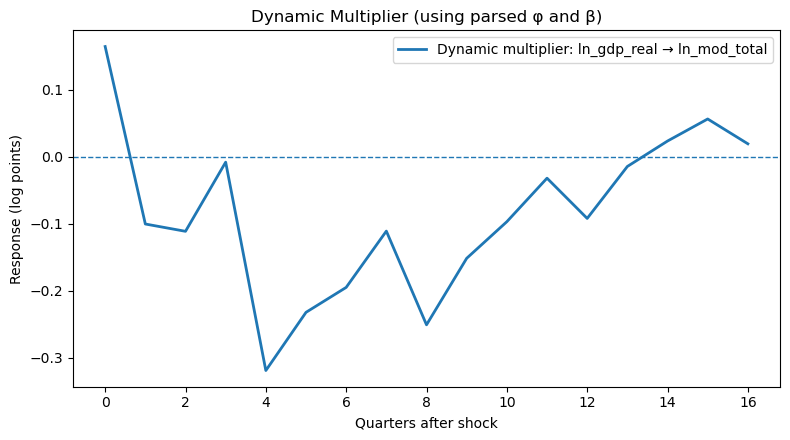

In [4]:
# Fix long-run elasticity & dynamic multipliers for statsmodels that name params as 'var.Lk'
import re, inspect, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL, ardl_select_order

# ---------- Reuse fitted ARDL if available; otherwise refit quickly ----------
try:
    _ = res  # from previous cell
    _ = model
    ycol = "ln_mod_total"
except NameError:
    # minimal refit (same as before)
    pq = Path("data/processed/ardl_ready_panel.parquet")
    csv = Path("data/processed/ardl_ready_panel.csv")
    if pq.exists():
        ardl_ready = pd.read_parquet(pq)
    elif csv.exists():
        ardl_ready = pd.read_csv(csv, parse_dates=["quarter_end"]).set_index("quarter_end")
    else:
        raise FileNotFoundError("Cannot find ardl_ready_panel in data/processed/")
    dfm = ardl_ready.dropna(subset=["ln_mod_total","ln_gdp_real"]).copy()
    y = dfm["ln_mod_total"]
    X = dfm[["ln_gdp_real","D_brexit_step","D_covid_step","D_ukraine_step",
             "D_brexit_qtr","D_covid_qtr","D_ukraine_qtr"]].dropna(axis=1, how="all")
    ycol = "ln_mod_total"
    # API-robust selection
    from statsmodels.tsa.ardl import ardl_select_order
    exog_max = {"ln_gdp_real": 6}
    for d in [c for c in X.columns if c != "ln_gdp_real"]:
        exog_max[d] = 0
    sel_kwargs = dict(endog=y, maxlag=6, exog=X, trend="c", ic="aic")
    sig = inspect.signature(ardl_select_order)
    if "maxorder" in sig.parameters: sel_kwargs["maxorder"] = exog_max
    elif "maxlag_exog" in sig.parameters: sel_kwargs["maxlag_exog"] = exog_max
    sel = ardl_select_order(**sel_kwargs)
    model = sel.model
    res = model.fit()

# ---------- Helper: parse lagged params in BOTH naming styles ----------
def collect_lags(params, varname):
    """
    Return sorted list of (lag, coef) for given varname,
    matching 'Lk.var' and 'var.Lk' styles.
    """
    pairs = []
    for name, val in params.items():
        # Style A: 'L1.var'
        mA = re.match(rf"^L(\d+)\.{re.escape(varname)}$", name)
        if mA:
            pairs.append((int(mA.group(1)), float(val)))
            continue
        # Style B: 'var.L1'
        mB = re.match(rf"^{re.escape(varname)}\.L(\d+)$", name)
        if mB:
            pairs.append((int(mB.group(1)), float(val)))
    pairs.sort()
    return pairs

# ---------- Get φ (y lags) and β (x distributed lags) ----------
phi = collect_lags(res.params, ycol)            # e.g., ('ln_mod_total.L1', ...)
bet = collect_lags(res.params, "ln_gdp_real")   # e.g., ('ln_gdp_real.L0', ...)

phi_sum = sum(v for _, v in phi)
beta_sum = sum(v for _, v in bet)
lr = np.nan if (1 - phi_sum) == 0 else beta_sum / (1 - phi_sum)

print("=== Recomputed long-run quantities ===")
print(f" φ (y) coefficients: {phi}")
print(f" β (x) coefficients: {bet}")
print(f" Sum φ: {phi_sum:.4f}")
print(f" Sum β: {beta_sum:.4f}")
print(f" Long-run elasticity (β_sum / (1-φ_sum)): {lr:.4f}")

# ---------- Build ECM again with correct p and q ----------
p = max([lag for lag, _ in phi] + [0])
q = max([lag for lag, _ in bet] + [0])

# Rebuild data used in the original fit
try:
    dfm  # noqa
except NameError:
    # reconstruct dfm from res.model._data if possible
    # safer: reload from disk
    pq = Path("data/processed/ardl_ready_panel.parquet")
    csv = Path("data/processed/ardl_ready_panel.csv")
    if pq.exists():
        full = pd.read_parquet(pq)
    else:
        full = pd.read_csv(csv, parse_dates=["quarter_end"]).set_index("quarter_end")
    dfm = full.dropna(subset=["ln_mod_total","ln_gdp_real"]).copy()
    
dummies = [c for c in dfm.columns if c.startswith("D_")]
work = dfm[[ycol,"ln_gdp_real"] + dummies].copy()
work["dy"] = work[ycol].diff()
work["dx"] = work["ln_gdp_real"].diff()
work["y_lag1"] = work[ycol].shift(1)
work["x_lag1"] = work["ln_gdp_real"].shift(1)

for i in range(1, p):      # Δy_{t-1}..Δy_{t-(p-1)}
    work[f"dy_lag{i}"] = work["dy"].shift(i)
for k in range(0, q):      # Δx_{t}..Δx_{t-(q-1)}
    work[f"dx_lag{k}"] = work["dx"].shift(k)

reg_cols = ["y_lag1","x_lag1"] + \
           [c for c in work.columns if c.startswith("dy_lag")] + \
           [c for c in work.columns if c.startswith("dx_lag")] + dummies

ecm = work.dropna(subset=["dy"] + reg_cols).copy()
Y = ecm["dy"]
X = sm.add_constant(ecm[reg_cols])
ecm_fit = sm.OLS(Y, X).fit()
print("\n=== ECM (recomputed with selected p, q) ===")
print(ecm_fit.summary())

# ---------- Dynamic multipliers using φ and β ----------
phi_dict = {lag: val for lag, val in phi}
beta_dict = {lag: val for lag, val in bet}
H = 16
mu = np.zeros(H+1)
mu[0] = beta_dict.get(0, 0.0)
for h in range(1, H+1):
    acc = beta_dict.get(h, 0.0)
    for i in range(1, min(p, h) + 1):
        acc += phi_dict.get(i, 0.0) * mu[h - i]
    mu[h] = acc

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(range(H+1), mu, lw=2, label="Dynamic multiplier: ln_gdp_real → ln_mod_total")
ax.axhline(0, ls="--", lw=1)
ax.set_xlabel("Quarters after shock")
ax.set_ylabel("Response (log points)")
ax.set_title("Dynamic Multiplier (using parsed φ and β)")
ax.legend()
plt.tight_layout()
figdir = Path("figures"); figdir.mkdir(parents=True, exist_ok=True)
outp = figdir / "dynamic_multiplier_ln_gdp_to_mod_total_FIXED.png"
fig.savefig(outp, dpi=300, bbox_inches="tight")
print(f"\nSaved fixed dynamic multiplier plot to: {outp}")
plt.show()

C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\Aniruddha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


=== Selected orders by AIC ===
 y lags (p): None
 exog lags:  None
AIC: -348.597

=== ARDL results (levels form) ===
                                ARDL Model Results                                
Dep. Variable:               ln_mod_total   No. Observations:                   76
Model:             ARDL(5, 5, 0, 0, 0, 0)   Log Likelihood                 191.299
Method:                   Conditional MLE   S.D. of innovations              0.016
Date:                    Tue, 02 Sep 2025   AIC                           -348.597
Time:                            01:30:11   BIC                           -310.132
Sample:                        09-30-2006   HQIC                          -333.301
                             - 03-31-2024                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.9566      1.781      2.

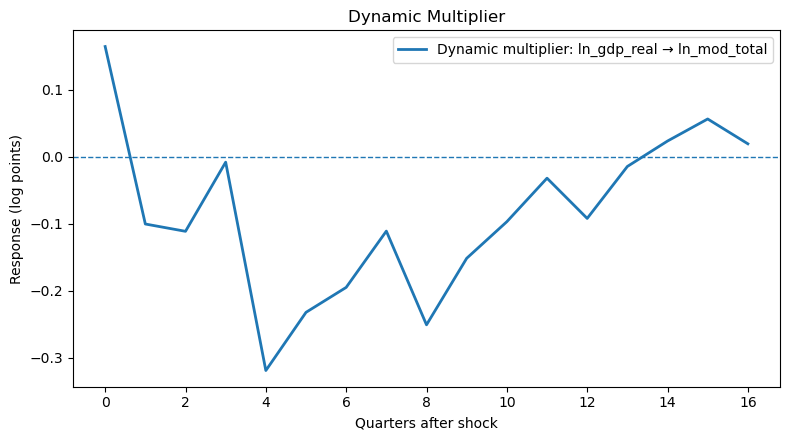

In [5]:
# ARDL/ECM for ln_mod_total on ln_gdp_real (+ dummies), with robust parsing & final multiplier
import warnings, inspect, re
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ardl import ARDL, ardl_select_order

# ---------------- Load ARDL-ready data ----------------
try:
    _ = ardl_ready  # reuse if present
except NameError:
    pq = Path("data/processed/ardl_ready_panel.parquet")
    csv = Path("data/processed/ardl_ready_panel.csv")
    if pq.exists():
        ardl_ready = pd.read_parquet(pq)
    elif csv.exists():
        ardl_ready = pd.read_csv(csv, parse_dates=["quarter_end"]).set_index("quarter_end")
    else:
        raise FileNotFoundError("Cannot find data/processed/ardl_ready_panel.[parquet|csv]")

df = ardl_ready.copy()

# ---------------- Variables ----------------
ycol = "ln_mod_total"
xcore = ["ln_gdp_real"]
dummy_candidates = [
    "D_brexit_step","D_covid_step","D_ukraine_step",
    "D_brexit_qtr","D_covid_qtr","D_ukraine_qtr"
]
dums = [c for c in dummy_candidates if c in df.columns]

# Only rows with y and core x
dfm = df.dropna(subset=[ycol] + xcore).copy()
y = dfm[ycol]
X = dfm[xcore + dums]

# ---------------- AIC lag selection (API-robust) ----------------
max_lag_y = 6
exog_max = {"ln_gdp_real": 6}
for d in dums:
    exog_max[d] = 0  # no lags on dummies

sel_kwargs = dict(endog=y, maxlag=max_lag_y, exog=X, trend="c", ic="aic")
sig = inspect.signature(ardl_select_order)
if "maxorder" in sig.parameters:
    sel_kwargs["maxorder"] = exog_max   # older statsmodels
elif "maxlag_exog" in sig.parameters:
    sel_kwargs["maxlag_exog"] = exog_max  # newer statsmodels

sel = ardl_select_order(**sel_kwargs)
model = sel.model
res = model.fit()

print("=== Selected orders by AIC ===")
print(f" y lags (p): {getattr(model, 'lags', None)}")
print(" exog lags: ", getattr(model, "exog_lags", None))
print(f"AIC: {res.aic:,.3f}\n")

print("=== ARDL results (levels form) ===")
print(res.summary())

# ---------------- Bounds test (if available in this build) ----------------
try:
    from statsmodels.tsa.ardl import ardl_bounds_test
    bt = ardl_bounds_test(res, case=3)  # Case III: constant
    stat = getattr(bt, "stat", getattr(bt, "statistic", np.nan))
    cvs  = getattr(bt, "critical_values", getattr(bt, "cv", None))
    print("\n=== Bounds test (Pesaran–Shin–Smith, case III: constant) ===")
    print(f" F-statistic: {stat:.3f}")
    if cvs is not None:
        try:
            for k, (i0, i1) in cvs.items():
                print(f"  {k} bounds: I(0)={i0:.3f}, I(1)={i1:.3f}")
        except Exception:
            print(cvs)
except Exception as e:
    print("\n[Note] Bounds test not available in this statsmodels build.")
    print(f"      Details: {e}")

# ---------------- Robust coefficient parser (both naming styles) ----------------
def collect_lags(params, varname):
    """
    Return sorted list of (lag, coef) for varname, matching 'Lk.var' and 'var.Lk'.
    """
    pairs = []
    for name, val in params.items():
        mA = re.match(rf"^L(\d+)\.{re.escape(varname)}$", name)      # 'L1.var'
        mB = re.match(rf"^{re.escape(varname)}\.L(\d+)$", name)      # 'var.L1'
        if mA:
            pairs.append((int(mA.group(1)), float(val)))
        elif mB:
            pairs.append((int(mB.group(1)), float(val)))
    pairs.sort()
    return pairs

phi = collect_lags(res.params, ycol)             # AR lags on y
bet = collect_lags(res.params, "ln_gdp_real")    # distributed lags on x

phi_sum = sum(v for _, v in phi)
beta_sum = sum(v for _, v in bet)
lr = np.nan if (1 - phi_sum) == 0 else beta_sum / (1 - phi_sum)

print("\n=== Long-run quantities (parsed) ===")
print(f" φ (y) coeffs: {phi}")
print(f" β (x) coeffs: {bet}")
print(f" Sum φ: {phi_sum:.4f}")
print(f" Sum β: {beta_sum:.4f}")
print(f" Long-run elasticity (β_sum / (1-φ_sum)): {lr:.4f}")

# ---------------- ECM (short-run dynamics) using selected p, q ----------------
p = max([lag for lag, _ in phi] + [0])
q = max([lag for lag, _ in bet] + [0])

work = dfm[[ycol,"ln_gdp_real"] + dums].copy()
work["dy"] = work[ycol].diff()
work["dx"] = work["ln_gdp_real"].diff()
work["y_lag1"] = work[ycol].shift(1)
work["x_lag1"] = work["ln_gdp_real"].shift(1)

for i in range(1, p):      # Δy_{t-1}..Δy_{t-(p-1)}
    work[f"dy_lag{i}"] = work["dy"].shift(i)
for k in range(0, q):      # Δx_{t}..Δx_{t-(q-1)}
    work[f"dx_lag{k}"] = work["dx"].shift(k)

reg_cols = ["y_lag1","x_lag1"] + \
           [c for c in work.columns if c.startswith("dy_lag")] + \
           [c for c in work.columns if c.startswith("dx_lag")] + dums

ecm_data = work.dropna(subset=["dy"] + reg_cols).copy()
Y_ecm = ecm_data["dy"]
X_ecm = sm.add_constant(ecm_data[reg_cols])
ecm_res = sm.OLS(Y_ecm, X_ecm).fit()

print("\n=== ECM (short-run) regression ===")
print(ecm_res.summary())

# ---------------- Dynamic multipliers from φ and β ----------------
# μ_0 = β0 ; μ_h = β_h + Σ_{i=1..p} φ_i * μ_{h-i} with β_h=0 for h>q
phi_dict = {lag: val for lag, val in phi}
beta_dict = {lag: val for lag, val in bet}

H = 16  # quarters
mu = np.zeros(H+1)
mu[0] = beta_dict.get(0, 0.0)
for h in range(1, H+1):
    acc = beta_dict.get(h, 0.0)
    for i in range(1, min(p, h) + 1):
        acc += phi_dict.get(i, 0.0) * mu[h - i]
    mu[h] = acc

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.plot(range(H+1), mu, lw=2, label="Dynamic multiplier: ln_gdp_real → ln_mod_total")
ax.axhline(0, lw=1, ls="--")
ax.set_xlabel("Quarters after shock")
ax.set_ylabel("Response (log points)")
ax.set_title("Dynamic Multiplier")
ax.legend()
plt.tight_layout()

figdir = Path("figures"); figdir.mkdir(parents=True, exist_ok=True)
outp = figdir / "dynamic_multiplier_ln_gdp_to_mod_total_FINAL.png"
fig.savefig(outp, dpi=300, bbox_inches="tight")
print(f"\nSaved dynamic multiplier plot to: {outp}")
plt.show()